# 🏗️ Projet Capstone Vinci - Détection des Contours de Pièces sur Plans Architecturaux
## **CapstoneVisionSegmentation :**   
### *Détection des contours de pièces basée sur la génération d’images binaires et l’analyse de contours par Computer Vision*

Auteur : Fabien Lagnieu

Date : 2025-03-10

## 📖 Note Book explicatif

---
## 🎯 Objectif

Ce notebook explique la mise en œuvre du pipeline complet de traitement de fichiers GeoJSON pour :
- Générer une image binaire à partir des segments vectoriels.
- Détecter les contours des pièces, supprimer les murs, et exporter les résultats en GeoJSON.

Les plans traités sont issus de fichiers au format GeoJSON, représentant les segments des murs d’un bâtiment.  
👉 Les plans GeoJSON à analyser doivent être mis dans le dossier `00_input_geojson/`

Les plans générés sont au format GeoJSON et représentent les contours des différentes pièces détectées.  
👉 Les plans générés sont sauvegardés dans le dossier `05_rooms_contours_geojson/`

Une interface graphique permet de lancer le traitement des fichiers et d'afficher le résultat.  
👉 [Lien vers l'interface graphique](./Interface_interactive.ipynb)



***Dans ce notebook, seuls cinq plans seront traités aléatoirement pour affichage des résultats.***

In [2]:
%load_ext autoreload
%autoreload 2

import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import tools.parse_geojson as pg
import capstone_contours_generation as ccg
import tools.visualization_tools as vt
import random

---
## 📁 Étape 1 : Création des dossiers de stockage

Avant de démarrer le pipeline, on initialise les répertoires de travail où seront stockés les fichiers intermédiaires :

-> Les plan geojson à analyser devont être mis dans le dossier `00_input_geojson/`

In [3]:
#Création des fichiers de stockage des données
input_dir = Path("00_input_geojson")
processed_dir = Path("01_processed_geojson")
binary_images_dir = Path("02_binary_images")
metadatas_dir = Path("03_metadatas")
contours_images_dir = Path("04_contours_images")
rooms_contours_geojson_dir = Path("05_rooms_contours_geojson")

for directory in [processed_dir, binary_images_dir, metadatas_dir, contours_images_dir, rooms_contours_geojson_dir]:
    directory.mkdir(parents=True, exist_ok=True)


---
## 🧹 Étape 2 : Nettoyage des GeoJSON et extraction des segments

🎯 Objectif

Préparer les fichiers GeoJSON bruts, souvent hétérogènes et non directement exploitables, en des objets géométriques simples et propres : des **segments de murs** sous forme de **LineStrings**.   

Ces segments serviront ensuite à générer l’image binaire dans l’étape suivante.

✅ Résultat :  
- Fichiers GeoJSON nettoyés, normalisés, dans le dossier `01_processed_geojson/`.  
- Format standardisé avec uniquement des LineStrings exploitables.

---

🔧 Étapes du nettoyage et de la génération des segments :

1. **Chargement du GeoJSON brut**  
   → Ouverture du fichier avec GeoPandas.

2. **Filtrage des géométries utiles**  
   → Sélection des Polygons, MultiPolygons, LineStrings, etc.

3. **Extraction des contours extérieurs**  
   → Récupération des coordonnées des contours (exterior).

4. **Découpage en segments (LineStrings)**  
   → Transformation de chaque contour en segments individuels.

5. **Suppression des doublons et segments invalides**  
   → Filtrage des segments trop courts ou dupliqués.

6. **Création d’un GeoDataFrame standardisé**  
   → Construction d’un GeoDataFrame propre contenant uniquement des segments.

7. **Sauvegarde du fichier GeoJSON nettoyé**  
   → Export dans le dossier `01_processed_geojson/`.


In [7]:
# Nettoyage et uniformisation des données d'entrée (geojson) en segments
files_names = []
for filepath in sorted(input_dir.iterdir()):
    files_names.append(filepath.stem)
    out_file = processed_dir / f"{filepath.stem}_clean.geojson"
    pg.clean_geojson_to_segments_and_save(filepath, out_file)

/opt/miniconda3/envs/M2datascience/lib/python3.12/site-packages/shapely/creation.py:460: RuntimeWarning: invalid value encountered in create_collection
  return lib.create_collection(geometries, typ, out=out, **kwargs)


#### 🔎 Visualisation des fichiers générés

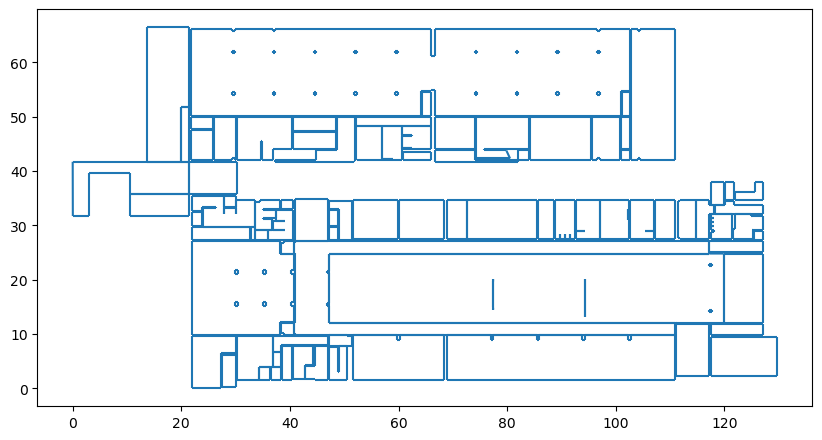

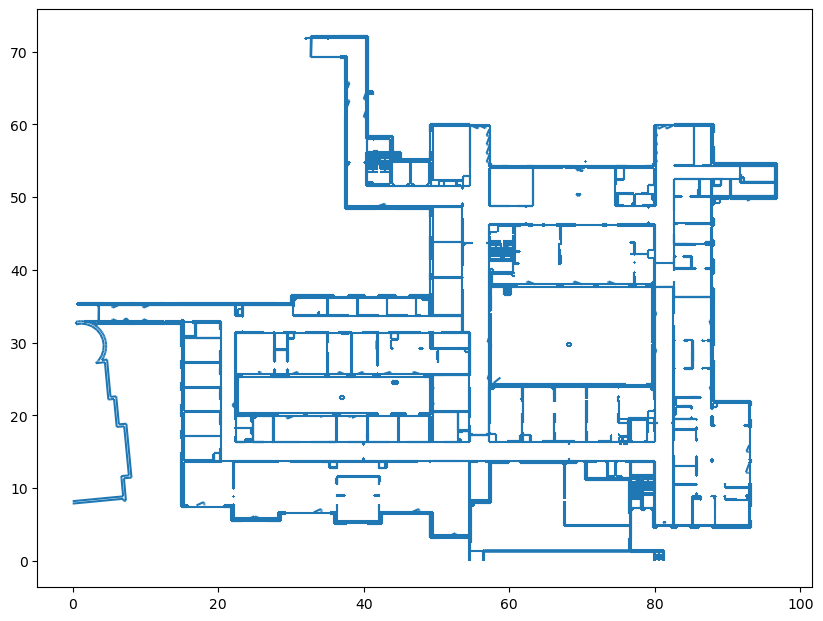

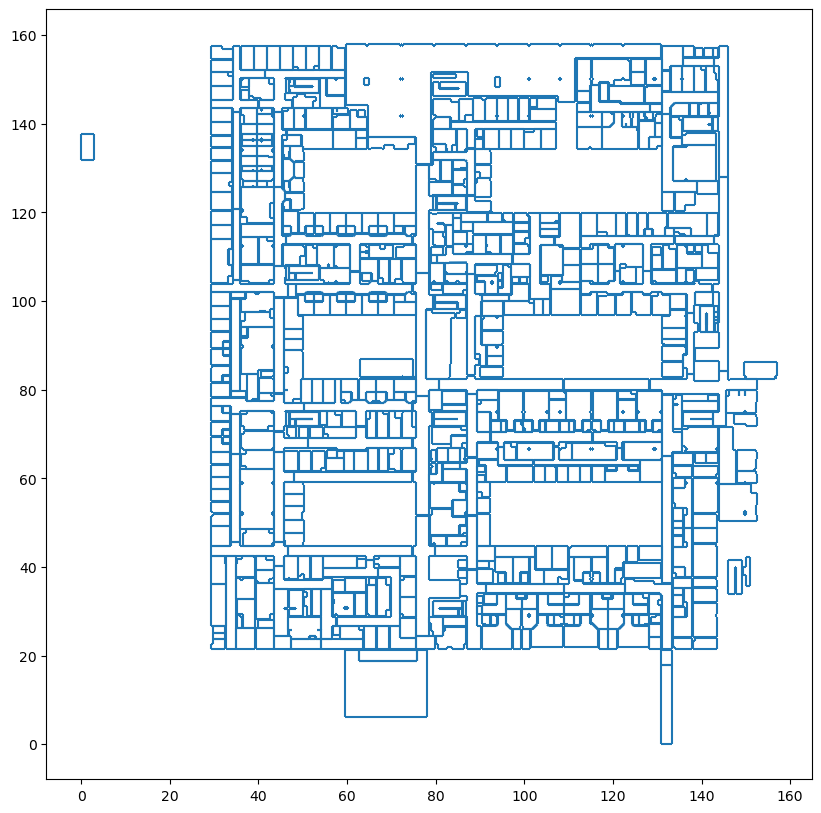

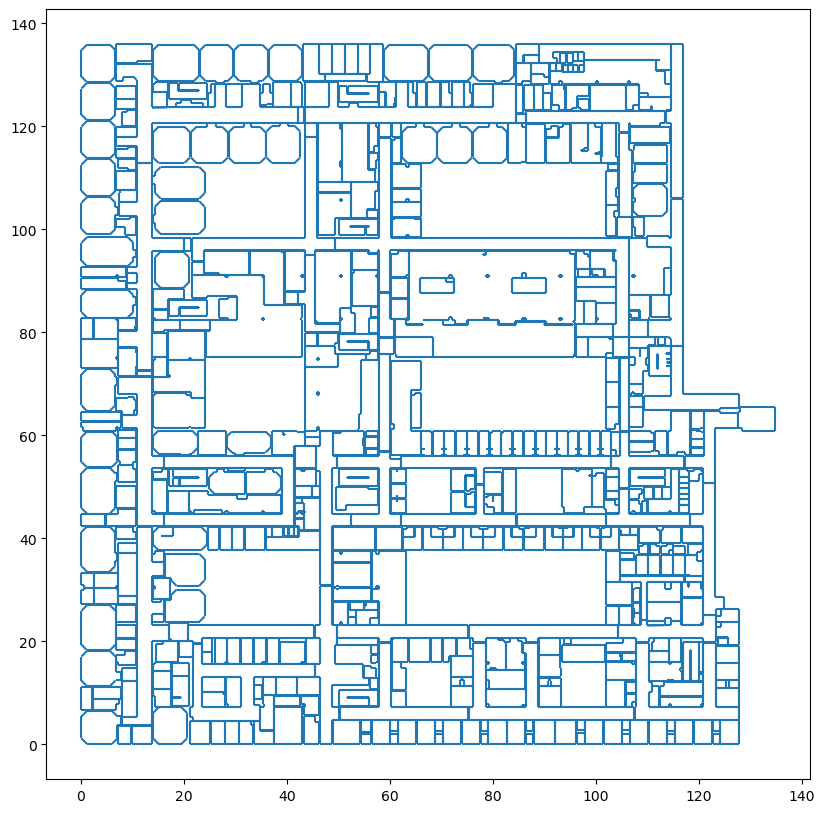

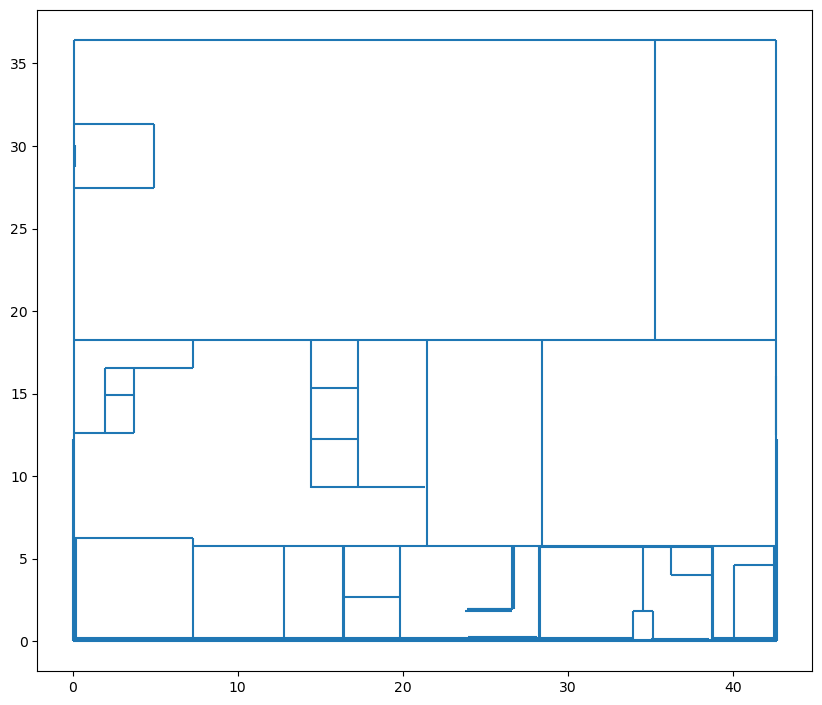

In [8]:
# Chargement des segments et affichage des plans
paths = []

# Limitation des affichages à 5 fichiers aléatoires
random.shuffle(files_names)
files_names = files_names[:5]

for file_name in files_names:
    paths.append(processed_dir / f"{file_name}_clean.geojson")

# Load the segments
segments = []
transform_parameters = []
for i, path in enumerate(paths):
    segment, transform_parameter = pg.load_segments(path)
    segments.append(segment)
    transform_parameters.append(transform_parameter)
    #print(f"Map number {i} has been loaded")
    #print(f"   Saved parameters for inverse transformation are: {transform_parameter}")
    #print(f"   Has loaded {len(segment.geoms)} segments, total {segment.length:.0f}m, mean length {segment.length/len(segment.geoms):.4f}m")

#Plot the segments
for i, segment in enumerate(segments):
    pg.plot_GeometryCollection(segment, figsize=(10, 10))

---
## 🖼️ Étape 3 : Génération des images binaires

🎯 **Objectif**

Transformer les segments de murs (`LineStrings`) en **images binaires**, où les murs sont représentés par des traits blancs sur fond noir.   
Ces images servent ensuite à l’analyse morphologique pour détecter les contours des pièces.

✅ **Résultat** :  
- Images binaires (format `PNG`) dans le dossier `02_binary_images/`.  
- Métadonnées de transformation spatiale (scale, offset, etc.) sauvegardées dans le dossier `03_metadatas/`.

---

🔧 **Étapes de génération des images binaires** :

1. **Chargement des segments**  
   → Lecture des fichiers `GeoJSON` nettoyés (uniquement des `LineStrings`) depuis le dossier `01_processed_geojson/`.

2. **Paramétrage de la résolution spatiale**  
   → Définition du `dpi_choice` (exemple : `50 dpi` → `1 mètre = 50 pixels`).  
   → La variable `scale` est alignée sur ce DPI pour respecter les proportions du plan.

3. **Définition de l’épaisseur des traits**  
   → Choix de l’épaisseur des murs en pixels avec `thickness_choice` (exemple : `9` pixels).  
   → Une valeur impaire est recommandée pour une symétrie optimale.

4. **Choix de la méthode de dilatation des traits**  
   → Trois options disponibles : `ellipse`, `cross` ou `gaussian`.  
   → La méthode `gaussian` est privilégiée pour gérer efficacement les traits courbes ou obliques.

5. **Transformation des coordonnées en image raster**  
   → Application des paramètres de `scale` et de translation pour convertir les coordonnées réelles en pixels sur une image.

6. **Génération de l’image binaire**  
   → Création d’une image `numpy` (fond noir).  
   → Dessin des `LineStrings` comme des traits blancs, représentant les murs.

7. **Sauvegarde des résultats**  
   → Export de l’image au format `PNG` dans le dossier `02_binary_images/`.  
   → Sauvegarde des métadonnées associées (paramètres de transformation) dans le dossier `03_metadatas/`.

In [9]:
# Générations d'images png noir et blanc, traits épaissis, à partir des segments et sauvegarde des métadonnées de transformation

# Paramètres pour la génération des images
dpi_choice = 50  # Changer la résolution ici (ex: 30, 50, 100...)
thickness_choice = 9  # Épaisseur des lignes en pixels (impair de préférence)
scale = dpi_choice  # 1m = dpi_choice pixels

# Méthode de dilatation ('ellipse', 'cross', 'gaussian' 
# -> gaussien est plus efficace pour l'épaississement des traits obliques et courbes)
method_choice = 'gaussian'

# Génération des images avec le DPI et épaisseur des traits choisis
for i, segment, file_name in zip(range(len(segments)), segments, files_names):
    ccg.generate_binary_image(
        segment,
        transform_parameters[i],
        file_name,
        binary_images_dir,
        metadatas_dir,
        scale=scale,
        thickness=thickness_choice,
        method=method_choice
    )

Saved binary map: 02_binary_images/Ecole_Centrale_Thomas_ARC_SYN_BAT-A-B-C_Spaces_binary_image.png
Saved transform metadata: 03_metadatas/Ecole_Centrale_Thomas_ARC_SYN_BAT-A-B-C_Spaces_metadata.json

Saved binary map: 02_binary_images/Output0_binary_image.png
Saved transform metadata: 03_metadatas/Output0_metadata.json

Saved binary map: 02_binary_images/NHT_Tours_plan_etage_T-T3000_Spaces_binary_image.png
Saved transform metadata: 03_metadatas/NHT_Tours_plan_etage_T-T3000_Spaces_metadata.json

Saved binary map: 02_binary_images/NHT_Tours_plan_etage_T-T3001_Spaces_binary_image.png
Saved transform metadata: 03_metadatas/NHT_Tours_plan_etage_T-T3001_Spaces_metadata.json

Saved binary map: 02_binary_images/autre_N0_Walls_binary_image.png
Saved transform metadata: 03_metadatas/autre_N0_Walls_metadata.json



#### 🔎 Visualisation des images binaires générées

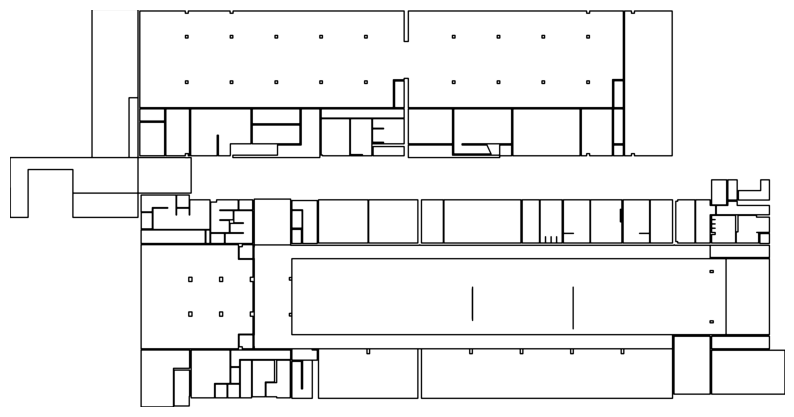

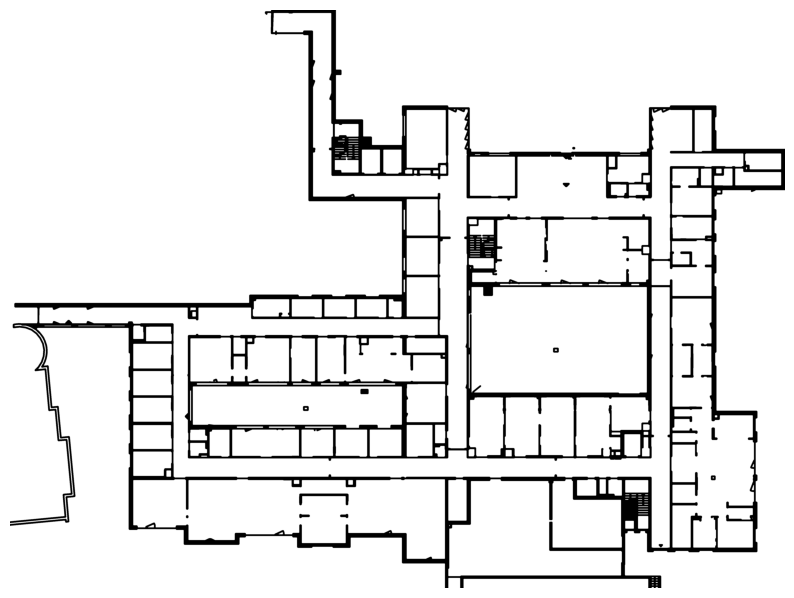

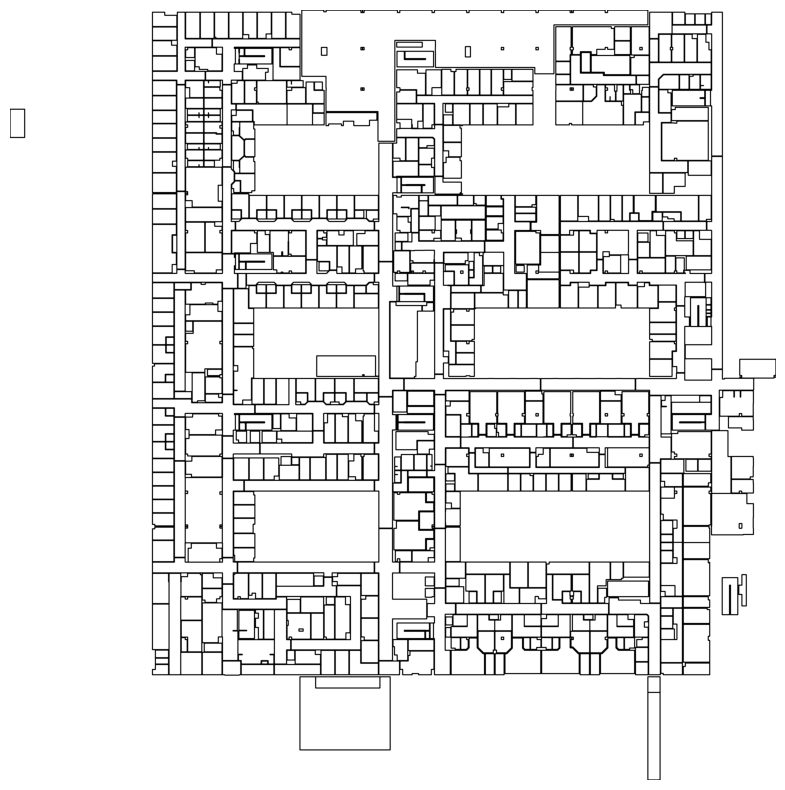

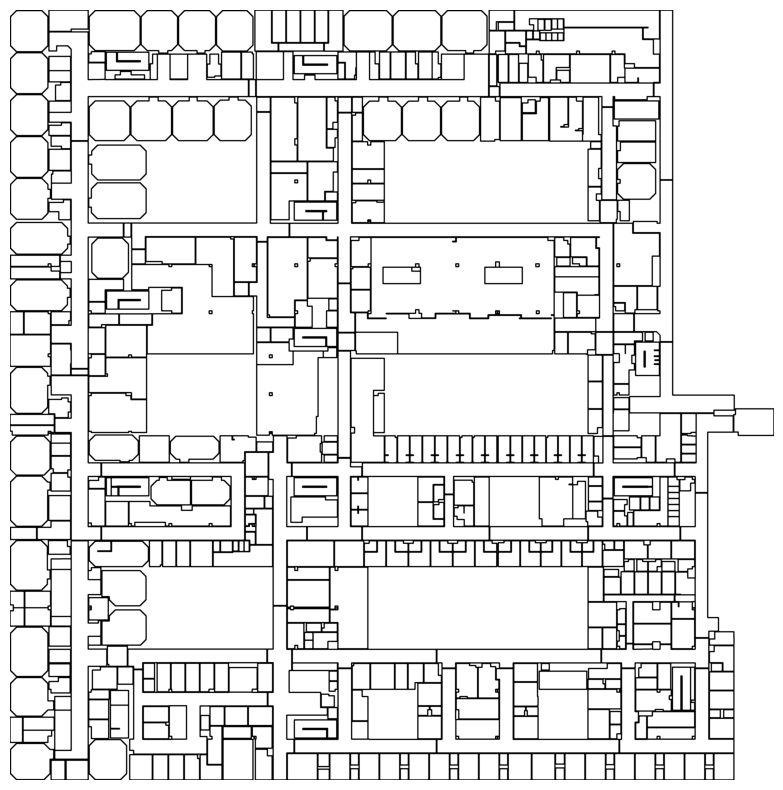

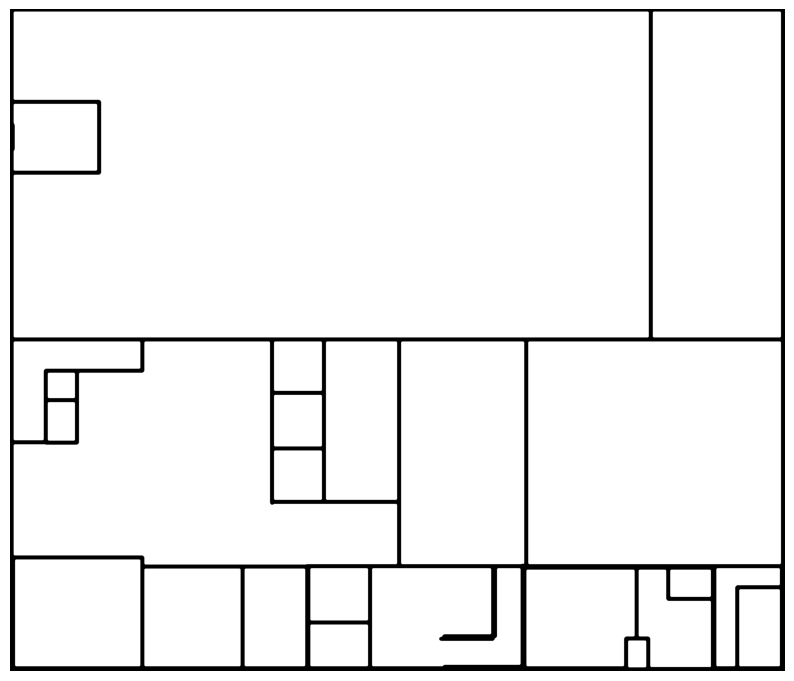

In [10]:
# Afficher les images binaires générées
for file_name in files_names:
    image_path = binary_images_dir / f"{file_name}_binary_image.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    #plt.title(f"{file_name}")
    plt.show()

## 🏠 Étape 4 : Détection des contours, filtrage des murs et export en GeoJSON

🎯 **Objectif**  
Analyser les **images binaires** générées à l’étape précédente afin de :  
- Détecter les **contours** des pièces  
- Filtrer les **zones parasites et murs**  
- Exporter les **pièces détectées** sous forme de polygones géoréférencés (GeoJSON)

✅ **Résultat attendu**  
- Une **image colorisée** avec les pièces détectées, dans le dossier `'04_contours_images/'`  
- Un **fichier GeoJSON** décrivant les contours des pièces, dans le dossier `'05_rooms_contours_geojson/'`  

---

🔧 **Étapes détaillées du traitement**

1. **Chargement des données**  
   → Lecture de l’image binaire avec `cv2.imread()`  
   → Lecture des métadonnées de transformation (coordonnées, échelle...)
  
2. **Prétraitement de l'image**   
   → Inversion des couleurs et binarisation avec `cv2.threshold()`  
   → Amélioration des zones fermées par **fermeture morphologique** avec `cv2.morphologyEx()`  


3. **Détection des contours**   
   → Extraction des contours et de leur hiérarchie avec `cv2.findContours()`  
   → La hiérarchie permet de prendre en compte la structure imbriquée des contours, en identifiant les relations parent-enfant entre les zones extérieures et leurs trous internes. C'est en particulier utile dans la détection des murs.

4. **Filtrage des murs et zones non pertinentes**    
   → Calcul des **surfaces** de chaque contour avec `cv2.contourArea()` en emputant les aires des contours imbiqués (hierarchie `child`)   
   → Calcul des **périmètres** avec `cv2.arcLength()`  
   → Suppression du **contour au plus long périmètre** qui correspond systématiquement au squelette principal des murs du bâtiment.   
   → Suppression des contours correspondant aux murs ou parasites en comparant **épaisseur** et **surface minimale**  
   → Tri des contours valides par **surface décroissante**  


5. **Conversion des coordonnées**    
   → Transformation des **coordonnées pixels** en **coordonnées géoréférencées (mètres)** à l'aide des métadonnées  


6. **Génération de l’image de visualisation**    
   → Création d’une **image couleur** à partir de l’image binaire avec `cv2.cvtColor()`  
   → Affichage et remplissage des contours retenus avec `cv2.drawContours()`  
   → Sauvegarde de l’image des pièces détectées dans le dossier `'04_contours_images/'` 


7. **Export des contours en GeoJSON**    
   → Création d’une **FeatureCollection** GeoJSON  
   → Conversion des contours en **Polygons** avec leurs propriétés (surface, nom, etc.)  
   → Enregistrement du fichier GeoJSON dans le dossier `'05_rooms_contours_geojson/'`



In [18]:
# Génération des pièces (image + geojson) à partir des images binaires et des métadonnées de transformation

surface_minimale=1 # surface minimale en m²
surface_minimale_pixels = surface_minimale * (dpi_choice**2)  # Conversion en pixels
epaisseur_min_m=0.4

for file_name in files_names:
    ccg.generer_pieces_image_et_geojson(
            file_name,
            binary_images_dir,
            metadatas_dir,
            contours_images_dir,
            rooms_contours_geojson_dir,
            surface_minimale=surface_minimale_pixels,
            dpi=dpi_choice,
            epaisseur_min_m=epaisseur_min_m, 
    )

✅ 82 pièces détectées pour 'Ecole_Centrale_Thomas_ARC_SYN_BAT-A-B-C_Spaces'.
✅ Image sauvegardée : 04_contours_images/Ecole_Centrale_Thomas_ARC_SYN_BAT-A-B-C_Spaces_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/Ecole_Centrale_Thomas_ARC_SYN_BAT-A-B-C_Spaces_rooms_contours.geojson

✅ 63 pièces détectées pour 'Output0'.
✅ Image sauvegardée : 04_contours_images/Output0_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/Output0_rooms_contours.geojson

✅ 627 pièces détectées pour 'NHT_Tours_plan_etage_T-T3000_Spaces'.
✅ Image sauvegardée : 04_contours_images/NHT_Tours_plan_etage_T-T3000_Spaces_contours_image.png
GeoJSON avec échelle enregistré : 05_rooms_contours_geojson/NHT_Tours_plan_etage_T-T3000_Spaces_rooms_contours.geojson

✅ 505 pièces détectées pour 'NHT_Tours_plan_etage_T-T3001_Spaces'.
✅ Image sauvegardée : 04_contours_images/NHT_Tours_plan_etage_T-T3001_Spaces_contours_image.png
GeoJSON avec échelle enregistré : 05_room

#### 🔎 Visualisation des différents contours de pèces détectées

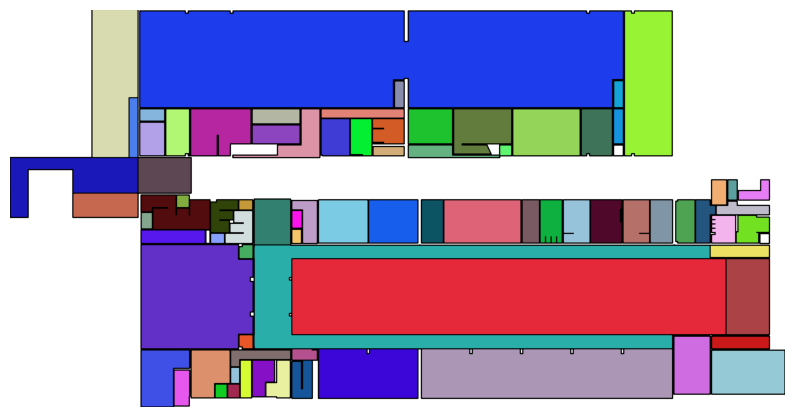

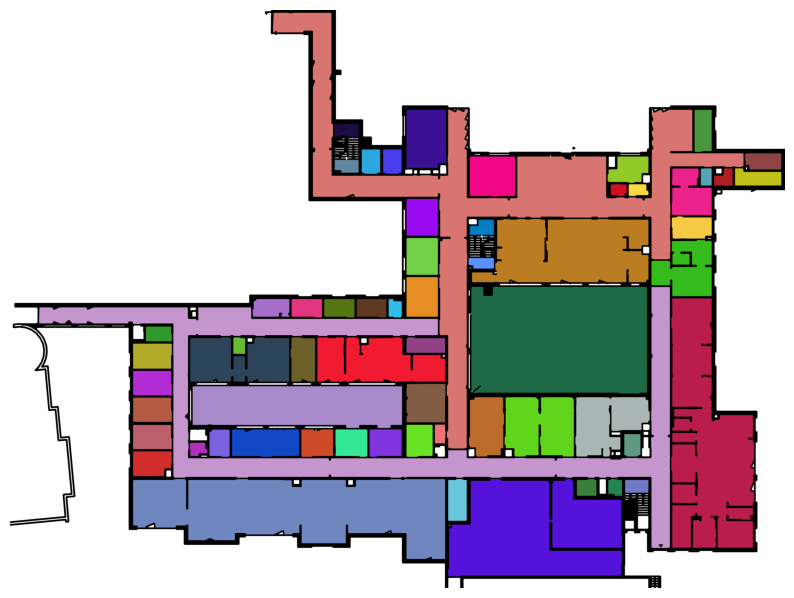

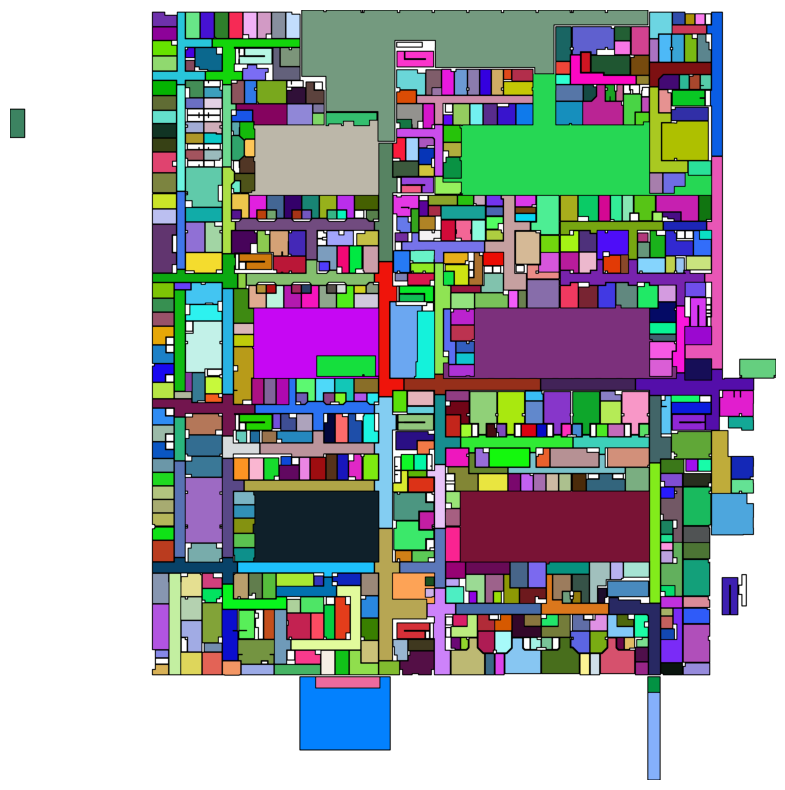

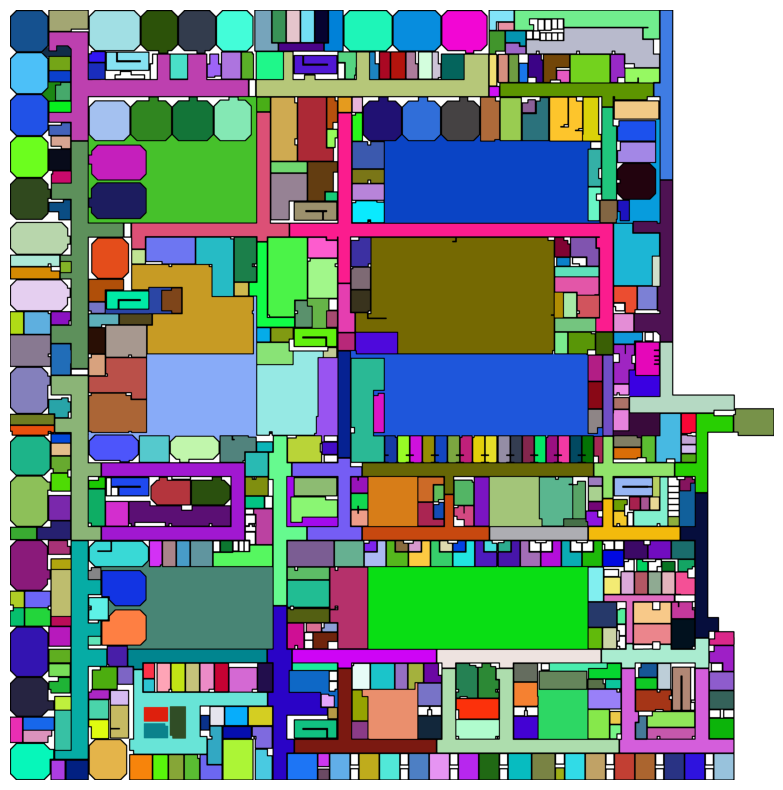

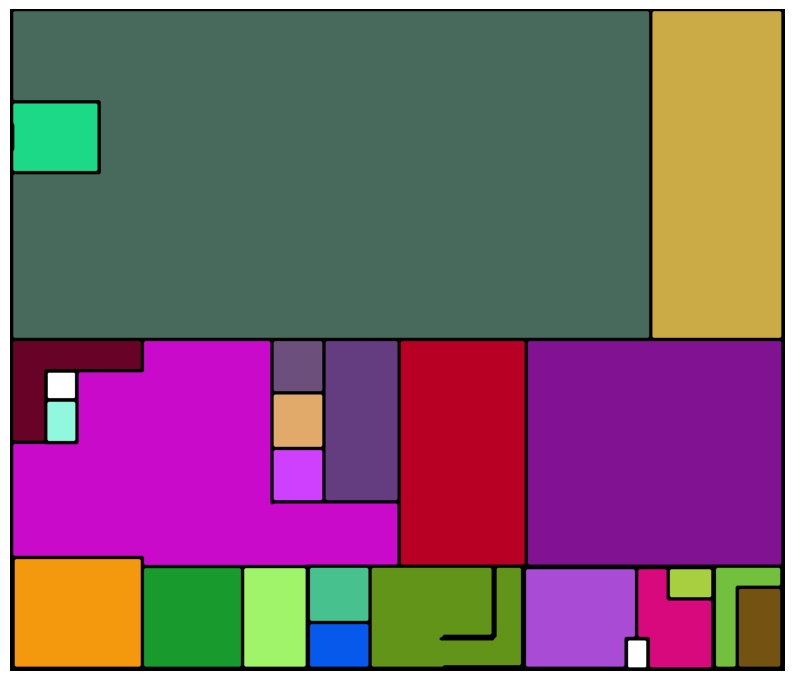

In [19]:
# Afficher les images binaires générées
for file_name in files_names:
    image_path = contours_images_dir / f"{file_name}_contours_image.png"
    binary_image = Image.open(image_path)
    plt.figure(figsize=(10, 10))
    plt.imshow(binary_image, cmap="gray")
    plt.axis("off")
    #plt.title(f"{file_name}")
    plt.show()

#### 🔎 Visualisation des fichiers GeoJSON de sortie générés 

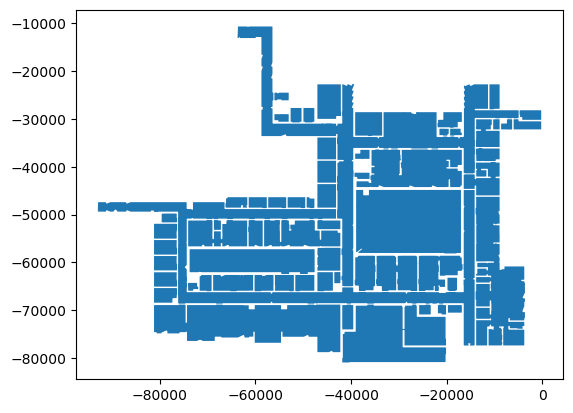

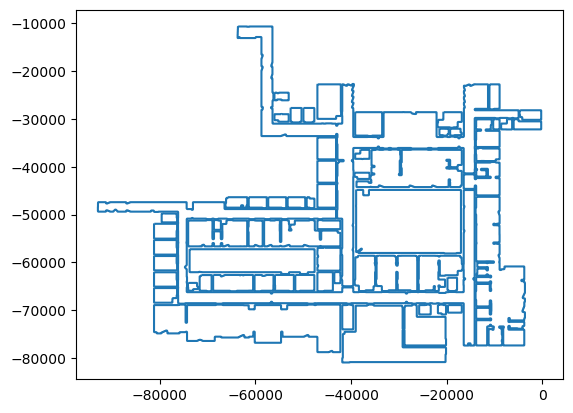

In [9]:
# Imprime les geojson : polygones & contours des pièces

for file_name in files_names:
    path = Path(rooms_contours_geojson_dir,f"{file_name}_rooms_contours.geojson")
    gdf = gpd.GeoDataFrame.from_file(path)
    gdf.plot(aspect=1)
    gdf.boundary.plot(aspect=1)

---
## ✅ Conclusion

Le **pipeline de traitement des plans GeoJSON** est désormais **opérationnel** ✅  
Il permet de traiter automatiquement des plans vectoriels, d'en extraire les **pièces** grâce à la détection de **contours filtrés**, et de générer des fichiers **prêts à l'emploi**.

### 🎯 Résultats produits :
- Une **image** avec les pièces détectées, enregistrée dans le dossier `04_contours_images/`  
- Un **fichier GeoJSON des contours des pièces**, enregistré dans le dossier `05_rooms_contours_geojson/`   


Une interface graphique permet de lancer le traitement des fichiers et d'afficher le résultat.  
👉 [Lien vers l'interface graphique](./Interface_interactive.ipynb)


